In [1]:
# Import libraries
import os

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import rioxarray as rxr
from rasterio.plot import plotting_extent
import geopandas as gpd
# Zonals stats package for extracting values
import rasterstats as rs
import earthpy as et
import earthpy.plot as ep

et.data.get_data("spatial-vector-lidar")
os.chdir(os.path.join(et.io.HOME,
                      "earth-analytics",
                      "data"))

In [2]:
# Review -- chm -- what is it

## Import Canopy Height Model
 

In [3]:
sjer_data_path = os.path.join("spatial-vector-lidar",
                              "california",
                              "neon-sjer-site")
sjer_chm_path = os.path.join(sjer_data_path,
                             "2013",
                             "lidar",
                             "SJER_lidarCHM.tif")

sjer_lidar_chm = rxr.open_rasterio(sjer_chm_path,
                                   masked=True).squeeze()

sjer_plot_extent = plotting_extent(sjer_lidar_chm.values,
                                   sjer_lidar_chm.rio.transform())

sjer_lidar_chm.shape

(5059, 4296)

## Plot a histogram

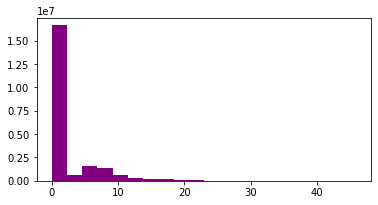

In [4]:
ep.hist(sjer_lidar_chm.values,
        figsize=(6, 3))
plt.show()

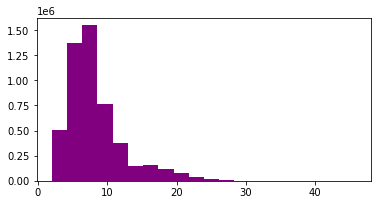

In [5]:
# Set all values ==0 to na (no data)
sjer_chm_data_no_zeros = sjer_lidar_chm.where(sjer_lidar_chm != 0, np.nan)

ep.hist(sjer_chm_data_no_zeros.values,
        figsize=(6, 3))
plt.show()

## Import The Plot Location Data

In [6]:
# Open up your plot locations - shapefile
sjer_centroids_path = os.path.join(sjer_data_path,
                                   "vector_data",
                                   "SJER_plot_centroids.shp")

sjer_plot_points = gpd.read_file(sjer_centroids_path)
# Notice that the geometry is in POINT format now
sjer_plot_points.head(3)

Plot_ID   Point     northing     easting plot_type  \
0  SJER1068  center  4111567.818  255852.376     trees   
1   SJER112  center  4111298.971  257406.967     trees   
2   SJER116  center  4110819.876  256838.760     grass   

                         geometry  
0  POINT (255852.376 4111567.818)  
1  POINT (257406.967 4111298.971)  
2  POINT (256838.760 4110819.876)

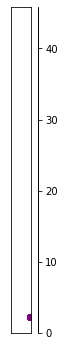

In [7]:
# The plot below looks funky -- look closely at the plot code
# Here, you can see that the extent is not provided for the raster data
fig, ax = plt.subplots(figsize=(6, 6))
ep.plot_bands(sjer_lidar_chm, cmap="Greys",
              # extent=sjer_plot_extent,
              ax=ax, scale=False)

# Overlay the geopandas VECTOR layer which contains data from your shapefile
sjer_plot_points.plot(ax=ax,
                      color="purple")
plt.show()

## Set  Your  Extent  and  The  Data  Overlay  Properly

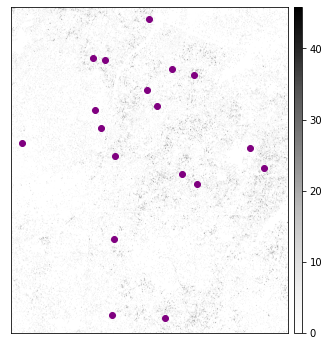

In [8]:
fig, ax = plt.subplots(figsize=(6, 6))
ep.plot_bands(sjer_lidar_chm, cmap="Greys",
              extent=sjer_plot_extent,
              ax=ax,
              scale=False)

# Plot a geopandas VECTOR layer (shapefile in this case)
sjer_plot_points.plot(ax=ax,
                      color="purple")
plt.show()

# Buffer the points to make a polygon 

In [9]:
# Buffer the points
sjer_plots_poly = sjer_plot_points.copy()
sjer_plots_poly["geometry"] = sjer_plot_points.geometry.buffer(20)
# View the top few lines - notice that the geometry is now in polygon rather than point format!
sjer_plots_poly.head()

Plot_ID   Point     northing     easting plot_type  \
0  SJER1068  center  4111567.818  255852.376     trees   
1   SJER112  center  4111298.971  257406.967     trees   
2   SJER116  center  4110819.876  256838.760     grass   
3   SJER117  center  4108752.026  256176.947     trees   
4   SJER120  center  4110476.079  255968.372     grass   

                                            geometry  
0  POLYGON ((255872.376 4111567.818, 255872.280 4...  
1  POLYGON ((257426.967 4111298.971, 257426.871 4...  
2  POLYGON ((256858.760 4110819.876, 256858.664 4...  
3  POLYGON ((256196.947 4108752.026, 256196.851 4...  
4  POLYGON ((255988.372 4110476.079, 255988.276 4...

In [10]:
# Export newly created buffer data as a shapefile
plot_buffer_path = os.path.join("spatial-vector-lidar",
                                "outputs",
                                "sjer_plot_buffer.shp")
sjer_plots_poly.to_file(plot_buffer_path)

## Zonal Stats To Create Spatial Data 

In the example below, you run zonal stats. There are many parameters below that you do'nt need if all you want to do is output the data (and you don't need the spatial elements. I have added additional steps below to show you how to ruun zonal stats and turn it into a spatial object that you can plot. 

run help(rs.zonal_stats) --to see what all of those parameters do below!
`help(rs.gen_zonal_stats)` <- this is actually the function with the full docstring that you'll want to look at.

In [11]:
# Run zonal stats
sjer_lidar_tree_heights = rs.zonal_stats(plot_buffer_path,
                                         sjer_lidar_chm.values,
                                         # This provides CRS information
                                         affine=sjer_lidar_chm.rio.transform(),
                                         geojson_out=True,
                                         copy_properties=True,
                                         nodata=0,
                                         stats=["mean", "max"])
type(sjer_lidar_tree_heights)

list

In [12]:
# While you don't need a GDF to do this analysis this will allow you to plot the data later by tree height!!
sjer_lidar_height_df = gpd.GeoDataFrame.from_features(sjer_lidar_tree_heights)
sjer_lidar_height_df.head()

geometry   Plot_ID   Point  \
0  POLYGON ((255872.376 4111567.818, 255872.280 4...  SJER1068  center   
1  POLYGON ((257426.967 4111298.971, 257426.871 4...   SJER112  center   
2  POLYGON ((256858.760 4110819.876, 256858.664 4...   SJER116  center   
3  POLYGON ((256196.947 4108752.026, 256196.851 4...   SJER117  center   
4  POLYGON ((255988.372 4110476.079, 255988.276 4...   SJER120  center   

      northing     easting plot_type        max       mean  
0  4111567.818  255852.376     trees  19.049999  11.544348  
1  4111298.971  257406.967     trees  24.019999  10.369277  
2  4110819.876  256838.760     grass  16.070000   7.518398  
3  4108752.026  256176.947     trees  11.059999   7.675347  
4  4110476.079  255968.372     grass   5.740000   4.591176

In [13]:
# Optional but recommended - rename columns to be clear about what metrics they contain
# note that inplace specifies that you want pandas to modify the original dataframe (in place) rather than creating a new object
sjer_lidar_height_df.rename(columns={"max": "lidar_max",
                                     "mean": "lidar_mean"},
                            inplace=True)  # Rename  the  columns in place

# Look at the new column names. they are more expressive than they were before.
# This will become important as you merge the insitu data with this data below!
sjer_lidar_height_df.head()

geometry   Plot_ID   Point  \
0  POLYGON ((255872.376 4111567.818, 255872.280 4...  SJER1068  center   
1  POLYGON ((257426.967 4111298.971, 257426.871 4...   SJER112  center   
2  POLYGON ((256858.760 4110819.876, 256858.664 4...   SJER116  center   
3  POLYGON ((256196.947 4108752.026, 256196.851 4...   SJER117  center   
4  POLYGON ((255988.372 4110476.079, 255988.276 4...   SJER120  center   

      northing     easting plot_type  lidar_max  lidar_mean  
0  4111567.818  255852.376     trees  19.049999   11.544348  
1  4111298.971  257406.967     trees  24.019999   10.369277  
2  4110819.876  256838.760     grass  16.070000    7.518398  
3  4108752.026  256176.947     trees  11.059999    7.675347  
4  4110476.079  255968.372     grass   5.740000    4.591176

## Compare Human Measured Tree Heights
Next you will import the data that has human measured tree heights. 
you will use this data to compare to the lidar data information that you calculated above!

conceptually the steps are similar but in this case you already have the data in a dataframe so you just need to calculate sumary statistics. 

In [14]:
# Import the csv of human measured (insitu) tree height data
path_insitu = os.path.join(sjer_data_path,
                           "2013",
                           "insitu",
                           "veg_structure",
                           "D17_2013_SJER_vegStr.csv")
sjer_insitu_all = pd.read_csv(path_insitu)
sjer_insitu_all.columns

# Keep only the needed columns - this is one way to subset a pandas dataframe by column name
sjer_insitu = sjer_insitu_all[["siteid", "sitename", "plotid", "stemheight"]]
sjer_insitu.head()

siteid     sitename    plotid  stemheight
0   SJER  San Joaquin   SJER128        18.2
1   SJER  San Joaquin  SJER2796         3.3
2   SJER  San Joaquin   SJER272         1.7
3   SJER  San Joaquin   SJER112         2.1
4   SJER  San Joaquin   SJER272         3.0

Below you are calculating the mean and max height value for each plot. you are using the `stemheight` column to calculate these values. 

In [15]:
# Get mean and max tree height for each plot
insitu_stem_ht = sjer_insitu.groupby(
    "plotid").agg(["mean", "max"])["stemheight"]
insitu_stem_ht = insitu_stem_ht.reset_index()
insitu_stem_ht.head()

plotid      mean   max
0  SJER1068  3.866667  19.3
1   SJER112  8.221429  23.9
2   SJER116  8.218750  16.0
3   SJER117  6.512500  11.0
4   SJER120  7.600000   8.8

## Rename Columns
Renaming columns can be useful to keep your data tidy and to keep track of what columns contains what metrics.

In [16]:
# It could be a good idea to rename columns so the data are clear
insitu_stem_ht.rename(columns={"mean": "insitu_mean",
                               "max": "insitu_max"},
                      inplace=True)
insitu_stem_ht.columns

Index(['plotid', 'insitu_mean', 'insitu_max'], dtype='object')

Once you are done, you can then MERGE the human measured tree height data sumnmarized above with the lidar summaries that you created. this creates ONE dataframe with all of the data you need to run your comparisons. 

In [17]:
# Merge the lidar df with the insitu by the plot id
sjer_final_height = sjer_lidar_height_df.merge(insitu_stem_ht,
                                               left_on="Plot_ID",
                                               right_on="plotid")

In [21]:
sjer_final_height.head(3)

geometry   Plot_ID   Point  \
0  POLYGON ((255872.376 4111567.818, 255872.280 4...  SJER1068  center   
1  POLYGON ((257426.967 4111298.971, 257426.871 4...   SJER112  center   
2  POLYGON ((256858.760 4110819.876, 256858.664 4...   SJER116  center   

      northing     easting plot_type  lidar_max  lidar_mean    plotid  \
0  4111567.818  255852.376     trees  19.049999   11.544348  SJER1068   
1  4111298.971  257406.967     trees  24.019999   10.369277   SJER112   
2  4110819.876  256838.760     grass  16.070000    7.518398   SJER116   

   insitu_mean  insitu_max  
0     3.866667        19.3  
1     8.221429        23.9  
2     8.218750        16.0

In [19]:
# Now you can plot your data using matplotlib. !

## Bonus! A Spatial Plot

Below you can just see how you created a new dataset that can also be plotted spatially which is pretty cool!!


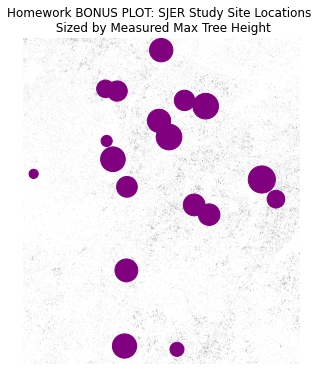

In [20]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.imshow(sjer_lidar_chm,
          cmap='Greys',
          extent=sjer_plot_extent)

# overlay field site locations
sjer_final_height.centroid.plot(ax=ax,
                                marker='o',
                                markersize=sjer_final_height['insitu_mean']*80,
                                color='purple')

# add title
ax.set_title(
    "Homework BONUS PLOT: SJER Study Site Locations \n Sized by Measured Max Tree Height")
ax.set_axis_off()
plt.show()